In [2]:
import pandas as pd
import numpy as np
import Risk_Kit as erk
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
n_scenarios = 5000
rates, zc_prices = erk.cir(10, n_scenarios=n_scenarios, b=0.03, r_0=0.03, sigma=0.02)
price_eq = erk.gbm(n_years=10, n_scenarios=n_scenarios, mu=0.07, sigma=0.15)

In [4]:
rets_eq = price_eq.pct_change().dropna()
rets_zc = zc_prices.pct_change().dropna()
rets_7030b = erk.bt_mix(rets_eq, rets_zc, allocator=erk.fixedmix_allocator, w1=0.7)
pd.concat([erk.terminal_stats(rets_zc, name="ZC", floor=0.75),
           erk.terminal_stats(rets_eq, name="Eq", floor=0.75),
           erk.terminal_stats(rets_7030b, name="70/30", floor=0.75)],
          axis=1).round(2)

,ZC,Eq,70/30
mean,1.07,1.97,1.64
std,0.01,0.96,0.55
p_breach,NaN,0.03,0.01
e_short,NaN,0.13,0.08
p_reach,NaN,NaN,NaN
e_surplus,NaN,NaN,NaN


In [5]:
rets_floor75 = erk.bt_mix(rets_eq, rets_zc, allocator=erk.floor_allocator, floor=0.75, zc_prices=zc_prices[1:])
pd.concat([erk.terminal_stats(rets_zc, name="ZC", floor=0.75),
           erk.terminal_stats(rets_eq, name="Eq", floor=0.75),
           erk.terminal_stats(rets_7030b, name="70/30", floor=0.75),
           erk.terminal_stats(rets_floor75, name="Floor75", floor=0.75),
          ],
          axis=1).round(2)

,ZC,Eq,70/30,Floor75
mean,1.07,1.97,1.64,1.88
std,0.01,0.96,0.55,0.97
p_breach,NaN,0.03,0.01,0.01
e_short,NaN,0.13,0.08,0.01
p_reach,NaN,NaN,NaN,NaN
e_surplus,NaN,NaN,NaN,NaN


In [6]:
rets_floor75m1 = erk.bt_mix(rets_eq, rets_zc, allocator=erk.floor_allocator, floor=0.75, zc_prices=zc_prices[1:], m=1)
rets_floor75m5 = erk.bt_mix(rets_eq, rets_zc, allocator=erk.floor_allocator, floor=0.75, zc_prices=zc_prices[1:], m=5)
pd.concat([erk.terminal_stats(rets_zc, name="ZC", floor=0.75),
           erk.terminal_stats(rets_eq, name="Eq", floor=0.75),
           erk.terminal_stats(rets_7030b, name="70/30", floor=0.75),
           erk.terminal_stats(rets_floor75, name="Floor75", floor=0.75),
           erk.terminal_stats(rets_floor75m1, name="Floor75m1", floor=0.75),
           erk.terminal_stats(rets_floor75m5, name="Floor75m5", floor=0.75)
          ],
          axis=1).round(4)

,ZC,Eq,70/30,Floor75,Floor75m1,Floor75m5
mean,1.0654,1.9685,1.6392,1.8797,1.3511,1.9192
std,0.0094,0.9634,0.5472,0.9689,0.3046,0.9876
p_breach,NaN,0.0344,0.0148,0.0074,NaN,0.0460
e_short,NaN,0.1270,0.0821,0.0087,NaN,0.0138
p_reach,NaN,NaN,NaN,NaN,NaN,NaN
e_surplus,NaN,NaN,NaN,NaN,NaN,NaN


## Risk Budgeting with Drawdown Constraints

In [7]:
cashrate = 0.02
monthly_cashreturn = (1+cashrate)**(1/12) -1
rets_cash = pd.DataFrame(data= monthly_cashreturn, index=rets_eq.index, columns=rets_eq.columns)
rets_maxdd25 = erk.bt_mix(rets_eq, rets_cash, allocator=erk.drawdown_allocator, maxdd=0.25)
tv_maxdd25 = erk.terminal_values(rets_maxdd25)
pd.concat([erk.terminal_stats(rets_zc, name="ZC", floor=0.75),
           erk.terminal_stats(rets_eq, name="Eq", floor=0.75),
           erk.terminal_stats(rets_7030b, name="70/30", floor=0.75),
           erk.terminal_stats(rets_floor75, name="Floor75", floor=0.75),
           erk.terminal_stats(rets_floor75m1, name="Floor75m1", floor=0.75),
           erk.terminal_stats(rets_floor75m5, name="Floor75m5", floor=0.75),
           erk.terminal_stats(rets_maxdd25, name="MaxDD25", floor=0.75)
          ],
          axis=1).round(4)

,ZC,Eq,70/30,Floor75,Floor75m1,Floor75m5,MaxDD25
mean,1.0654,1.9685,1.6392,1.8797,1.3511,1.9192,1.6274
std,0.0094,0.9634,0.5472,0.9689,0.3046,0.9876,0.5302
p_breach,NaN,0.0344,0.0148,0.0074,NaN,0.0460,NaN
e_short,NaN,0.1270,0.0821,0.0087,NaN,0.0138,NaN
p_reach,NaN,NaN,NaN,NaN,NaN,NaN,NaN
e_surplus,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
erk.summary_stats(rets_maxdd25)["Max Drawdown"].head()

0   -0.096786
1   -0.096644
2   -0.202958
3   -0.159567
4   -0.204350
Name: Max Drawdown, dtype: float64

In [9]:
erk.summary_stats(rets_maxdd25)["Max Drawdown"].min()

-0.23206651983963697

E:\zw\Anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
E:\zw\Anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
E:\zw\Anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
 

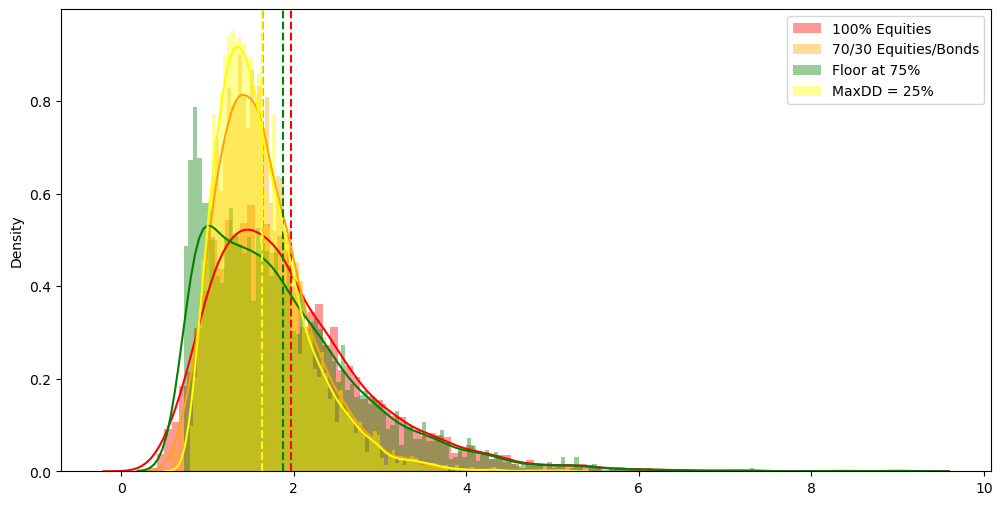

In [10]:
tv_eq = erk.terminal_values(rets_eq)
tv_zc = erk.terminal_values(rets_zc)
tv_7030b = erk.terminal_values(rets_7030b)
tv_floor75 = erk.terminal_values(rets_floor75)
tv_maxdd25 = erk.terminal_values(rets_maxdd25)

# Plot

plt.figure(figsize=(12, 6))
sns.distplot(tv_eq, color="red", label="100% Equities", bins=100)
plt.axvline(tv_eq.mean(), ls="--", color="red")
sns.distplot(tv_7030b, color="orange", label="70/30 Equities/Bonds", bins=100)
plt.axvline(tv_7030b.mean(), ls="--", color="orange")
sns.distplot(tv_floor75, color="green", label="Floor at 75%", bins=160)
plt.axvline(tv_floor75.mean(), ls="--", color="green")
sns.distplot(tv_maxdd25, color="yellow", label="MaxDD = 25%", bins=100)
plt.axvline(tv_maxdd25.mean(), ls="--", color="yellow" )

plt.legend();

# Drawdown Constraubr with Historical Data

<AxesSubplot:>

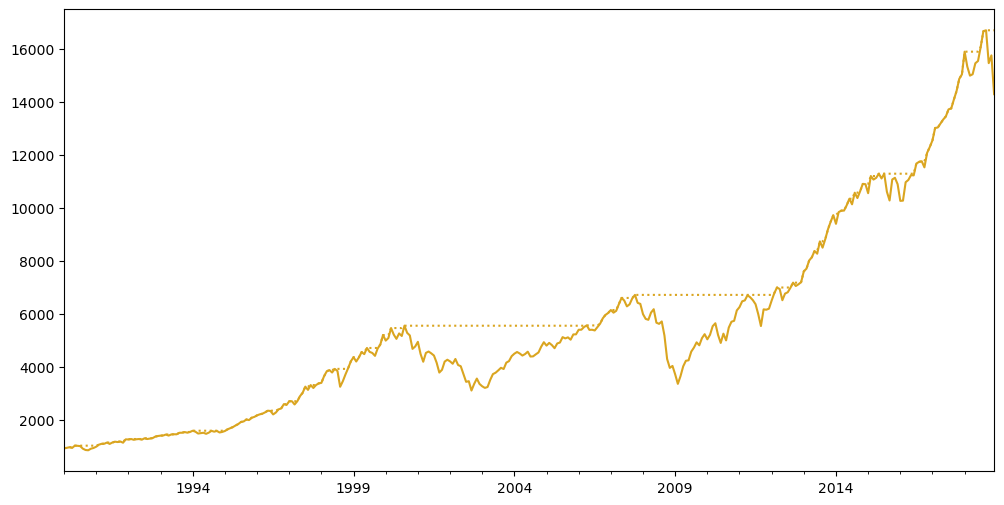

In [11]:
rets_tmi = erk.get_total_market_index_return()["1990":]
dd_tmi = erk.drawdown(rets_tmi)
ax = dd_tmi["Wealth"].plot(figsize=(12,6), ls="-", color="goldenrod")
dd_tmi["Peaks"].plot(ax=ax, ls=":", color="goldenrod")